## <center>CS551G - Data Mining and Visualisation</center>

# <center>Assessment II - Classification of Pressurised Water Reactor Status</center>

---

## <center>Author: Konstantin Georgiev</center>
### <center>Email: k.georgiev.19@abdn.ac.uk</center>

---

### Problem statement

&nbsp;&nbsp;&nbsp;The objective of this assessment is to analyse a large dataset concerning pressurised water reactor data, specifically on the properties involved in the fuel assemblies cluster vibrations, alterations of thermal and hydraulic parameters, etc. For over 70 years, the nuclear power industry – in the UK and worldwide – have primarily focused on the technological evolution of reliable nuclear power plants to produce electricity. By monitoring pressurised water reactors (a type of nuclear reactor), whilst operating at nominal conditions, it is possible to collect valuable insight and extract knowledge for early detection of abnormal events. Various types of fluctuations and perturbations can be caused by the turbulent nature of flow in the core, mechanical vibrations within the reactor, the boiling coolant and stochastic character (random noise). The dataset can be downloaded from MyAberdeen. It is based on data from a research project that investigates how to detect anomalies and events in pressurised water reactors. The dataset includes two classes (normal/abnormal condition) and a number of features, which will need to be utilised throughout this assessment.  The class membership of each row is stored in the field ‘Status’. The task is to develop a set of classification models for automatically classifying reactors as normal or abnormal, based on their parameters/features.

<b>Feature information in the dataset include:</b>
- Various vibration measurements in different parts of the reactor (four features)
- Various pressure values in different parts of the reactor (four features)
- Power levels in different parts of the reactor (four features)

<b>Status</b> refers to the condition of the nuclear reactor, or in other words, we consider this to be our label/annotation for the sake of all implementations (first column). As this is a binary classification task, all implementations should treat the problem as such.

<b>Unit of measurement or range of values of each feature are not relevant. However, features can be at different scales and/or measured in different units.</b>

---

### Project Structure

1.   <b> [Data acquisition.](#section1) </b>
2.   <b> [Exploratory Data Analysis.](#section2) </b>
3.   <b> [Logistic Regression model.](#section3) </b>
4.   <b> [Gradient-boosting tree model.](#section4)</b>
5.   <b> [Conclusion.](#section5)</b>

### Distributed models in Apache spark to classify nuclear reactor status

#### Importing libraries

##### Session

In [1]:
import os
os.environ["SPARK_HOME"] = "C:\spark-2.4.5-bin-hadoop2.7"
os.environ["JAVA_HOME"] = "C:\Progra~2\Java\jdk1.8.0_161"
import findspark
findspark.init()

import pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("SparkDataMining") \
    .getOrCreate()

##### Packages

In [2]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col

from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [10, 10]})

<a id='section1'></a>
#### Data Acquisition

In [3]:
np_data = spark.read.format("csv").option("header", "true").load("DMV_CS551G_Assignment 2-dataset-nuclear_plants.csv")

In [4]:
np_data.show()

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Normal|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|            21.648|           15.3429|            1.2186|
|Normal|        

In [5]:
np_features = np_data
np_label = np_data.select('Status')

In [6]:
np_features.printSchema()

root
 |-- Status: string (nullable = true)
 |-- Power_range_sensor_1: string (nullable = true)
 |-- Power_range_sensor_2: string (nullable = true)
 |-- Power_range_sensor_3 : string (nullable = true)
 |-- Power_range_sensor_4: string (nullable = true)
 |-- Pressure _sensor_1: string (nullable = true)
 |-- Pressure _sensor_2: string (nullable = true)
 |-- Pressure _sensor_3: string (nullable = true)
 |-- Pressure _sensor_4: string (nullable = true)
 |-- Vibration_sensor_1: string (nullable = true)
 |-- Vibration_sensor_2: string (nullable = true)
 |-- Vibration_sensor_3: string (nullable = true)
 |-- Vibration_sensor_4: string (nullable = true)



Rename (shorten) and correct the names of the columns 

In [7]:
for col in np_data.columns:
    col_clean = col.translate({ord(c): None for c in string.whitespace})
    if 'Power_range' in col_clean:
        col_clean = 'prs_' + col_clean[-1]
    elif 'Pressure_sensor' in col_clean:
        col_clean = 'ps_' + col_clean[-1]
    elif 'Vibration_sensor' in col_clean:
        col_clean = 'vs_' + col_clean[-1]
    
    np_features = np_features.withColumnRenamed(col, str(col_clean))

In [8]:
np_features.printSchema()

root
 |-- Status: string (nullable = true)
 |-- prs_1: string (nullable = true)
 |-- prs_2: string (nullable = true)
 |-- prs_3: string (nullable = true)
 |-- prs_4: string (nullable = true)
 |-- ps_1: string (nullable = true)
 |-- ps_2: string (nullable = true)
 |-- ps_3: string (nullable = true)
 |-- ps_4: string (nullable = true)
 |-- vs_1: string (nullable = true)
 |-- vs_2: string (nullable = true)
 |-- vs_3: string (nullable = true)
 |-- vs_4: string (nullable = true)



In [9]:
np_features.show()

+------+------+------+------+------+-------+------+-------+------+-------+-------+-------+-------+
|Status| prs_1| prs_2| prs_3| prs_4|   ps_1|  ps_2|   ps_3|  ps_4|   vs_1|   vs_2|   vs_3|   vs_4|
+------+------+------+------+------+-------+------+-------+------+-------+-------+-------+-------+
|Normal|4.5044|0.7443|  6.34|1.9052|29.5315|0.8647| 2.2044| 6.048|14.4659| 21.648|15.3429| 1.2186|
|Normal|4.4284|0.9073|5.6433|1.6232|27.5032|1.4704| 1.9929|5.9856|20.8356| 0.0646|14.8813| 7.3483|
|Normal|4.5291|1.0199| 6.113|1.0565|26.4271|1.9247|  1.942|6.7162| 5.3358|11.0779|25.0914| 9.2408|
|Normal|5.1727|1.0007|7.8589|0.2765|25.1576| 2.609| 2.9234|6.7485| 1.9017| 1.8463| 28.664| 4.0157|
|Normal|5.2258|0.6125|7.9504|0.1547|24.0765|3.2113| 4.4563|5.8411| 0.5077|   9.37|34.8122|13.4966|
|Normal|4.8834|0.5786|5.6021|0.5942|21.0365|2.6275| 4.3996|5.3487| 3.6465| 9.3793|36.2431| 11.124|
|Normal|5.7422|0.8862|5.1013|0.9402|15.5171|  2.92| 2.7061|5.0366| 9.1854| 9.1116|27.3162| 2.8526|
|Normal|6.

In [10]:
# Write a custom function to convert the data type of DataFrame columns
def convertColumn(df, names, newType):
    for name in names: 
        df = df.withColumn(name, df[name].cast(newType))
    return df

In [11]:
np_features = convertColumn(np_features, np_features.columns[1:], DoubleType())

In [12]:
np_features.printSchema()

root
 |-- Status: string (nullable = true)
 |-- prs_1: double (nullable = true)
 |-- prs_2: double (nullable = true)
 |-- prs_3: double (nullable = true)
 |-- prs_4: double (nullable = true)
 |-- ps_1: double (nullable = true)
 |-- ps_2: double (nullable = true)
 |-- ps_3: double (nullable = true)
 |-- ps_4: double (nullable = true)
 |-- vs_1: double (nullable = true)
 |-- vs_2: double (nullable = true)
 |-- vs_3: double (nullable = true)
 |-- vs_4: double (nullable = true)



Print some dataset statistics

In [13]:
np_features.describe('prs_1', 'prs_2', 'prs_3', 'prs_4').show()

+-------+------------------+-----------------+------------------+-----------------+
|summary|             prs_1|            prs_2|             prs_3|            prs_4|
+-------+------------------+-----------------+------------------+-----------------+
|  count|               996|              996|               996|              996|
|   mean|4.9995738935742935|6.379273152610441| 9.228112114457822| 7.35527208634539|
| stddev|2.7648555187192883|2.312568802265547|2.5321728908943326|4.354778181006018|
|    min|            0.0082|           0.0403|          2.583966|           0.0623|
|    max|           12.1298|          11.9284|           15.7599|        17.235858|
+-------+------------------+-----------------+------------------+-----------------+



Get a more detailed description using ```pandas```

In [14]:
np_pd_data = pd.read_csv('DMV_CS551G_Assignment 2-dataset-nuclear_plants.csv')
np_pd_features = np_pd_data.drop('Status', axis=1)
np_pd_features.describe()

,Power_range_sensor_1,Power_range_sensor_2,Power_range_sensor_3,Power_range_sensor_4,Pressure _sensor_1,Pressure _sensor_2,Pressure _sensor_3,Pressure _sensor_4,Vibration_sensor_1,Vibration_sensor_2,Vibration_sensor_3,Vibration_sensor_4
count,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000
mean,4.999574,6.379273,9.228112,7.355272,14.199127,3.077958,5.749234,4.997002,8.164563,10.001593,15.187982,9.933591
std,2.764856,2.312569,2.532173,4.354778,11.680045,2.126091,2.526136,4.165490,6.173261,7.336233,12.159625,7.282383
min,0.008200,0.040300,2.583966,0.062300,0.024800,0.008262,0.001224,0.005800,0.000000,0.018500,0.064600,0.009200
25%,2.892120,4.931750,7.511400,3.438141,5.014875,1.415800,4.022800,1.581625,3.190292,4.004200,5.508900,3.842675
50%,4.881100,6.470500,9.348000,7.071550,11.716802,2.672400,5.741357,3.859200,6.752900,8.793050,12.185650,8.853050
75%,6.794557,8.104500,11.046800,10.917400,20.280250,4.502500,7.503578,7.599900,11.253300,14.684055,21.835000,14.357400
max,12.129800,11.928400,15.759900,17.235858,67.979400,10.242738,12.647500,16.555620,36.186438,34.867600,53.238400,43.231400


In [15]:
np_pd_features.median()

Power_range_sensor_1      4.881100
Power_range_sensor_2      6.470500
Power_range_sensor_3      9.348000
Power_range_sensor_4      7.071550
Pressure _sensor_1       11.716802
Pressure _sensor_2        2.672400
Pressure _sensor_3        5.741357
Pressure _sensor_4        3.859200
Vibration_sensor_1        6.752900
Vibration_sensor_2        8.793050
Vibration_sensor_3       12.185650
Vibration_sensor_4        8.853050
dtype: float64

Check for missing values/NaNs

In [16]:
np_features.select([count(when(isnan(c), c)).alias(c) for c in np_features.columns]).show()

+------+-----+-----+-----+-----+----+----+----+----+----+----+----+----+
|Status|prs_1|prs_2|prs_3|prs_4|ps_1|ps_2|ps_3|ps_4|vs_1|vs_2|vs_3|vs_4|
+------+-----+-----+-----+-----+----+----+----+----+----+----+----+----+
|     0|    0|    0|    0|    0|   0|   0|   0|   0|   0|   0|   0|   0|
+------+-----+-----+-----+-----+----+----+----+----+----+----+----+----+



<a id='section2'></a>
#### Data Exploration

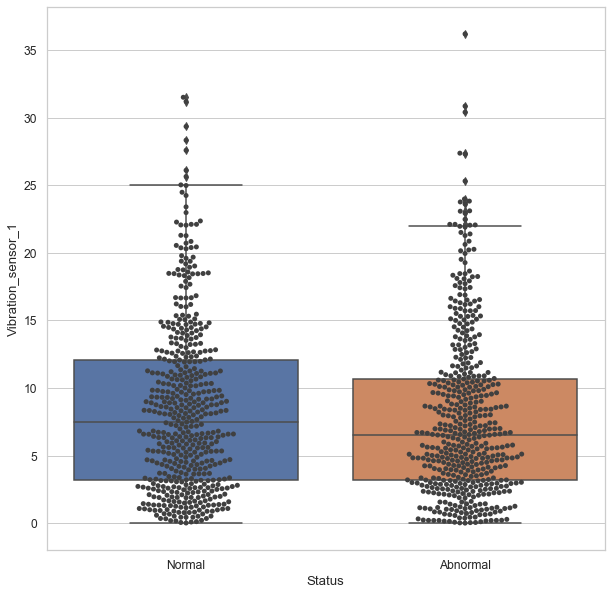

In [17]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [10, 10]})
ax = sns.boxplot(x="Status", y="Vibration_sensor_1", data=np_pd_data, dodge=False)
ax = sns.swarmplot(x="Status", y="Vibration_sensor_1", data=np_pd_data, color=".25")
plt.show()

In [18]:
pd.value_counts(np_pd_data['Status'])

Normal      498
Abnormal    498
Name: Status, dtype: int64

In [19]:
np_pd_normal = np_pd_data[np_pd_data['Status'] == 'Normal']
np_pd_abnormal = np_pd_data[np_pd_data['Status'] == 'Abnormal']

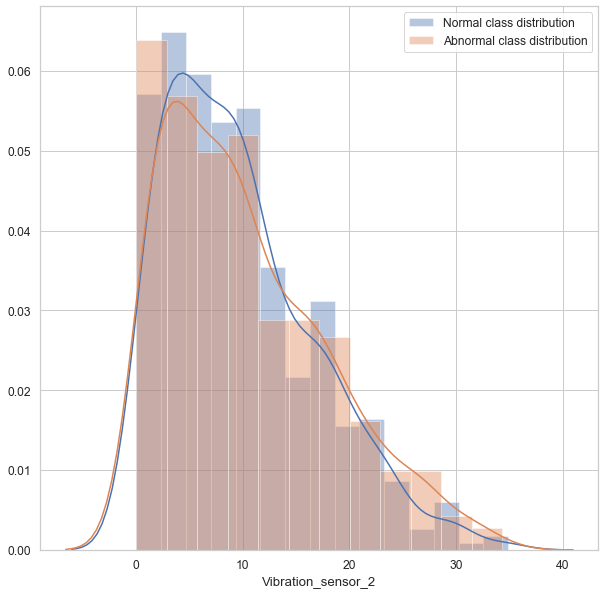

In [20]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [10, 10]})
sns.distplot(np_pd_normal['Vibration_sensor_2'], label='Normal class distribution')
sns.distplot(np_pd_abnormal['Vibration_sensor_2'], label='Abnormal class distribution')
plt.legend()
plt.show()

<a id='section3'></a>
#### Logistic Regression model

Encoding the label column

In [21]:
indexer = StringIndexer(inputCol="Status", outputCol="label")
np_features = indexer.fit(np_features).transform(np_features)
np_features = convertColumn(np_features, ["label"], IntegerType())
np_features = np_features.drop("Status")

In [22]:
np_features.show()

+------+------+------+------+-------+------+-------+------+-------+-------+-------+-------+-----+
| prs_1| prs_2| prs_3| prs_4|   ps_1|  ps_2|   ps_3|  ps_4|   vs_1|   vs_2|   vs_3|   vs_4|label|
+------+------+------+------+-------+------+-------+------+-------+-------+-------+-------+-----+
|4.5044|0.7443|  6.34|1.9052|29.5315|0.8647| 2.2044| 6.048|14.4659| 21.648|15.3429| 1.2186|    0|
|4.4284|0.9073|5.6433|1.6232|27.5032|1.4704| 1.9929|5.9856|20.8356| 0.0646|14.8813| 7.3483|    0|
|4.5291|1.0199| 6.113|1.0565|26.4271|1.9247|  1.942|6.7162| 5.3358|11.0779|25.0914| 9.2408|    0|
|5.1727|1.0007|7.8589|0.2765|25.1576| 2.609| 2.9234|6.7485| 1.9017| 1.8463| 28.664| 4.0157|    0|
|5.2258|0.6125|7.9504|0.1547|24.0765|3.2113| 4.4563|5.8411| 0.5077|   9.37|34.8122|13.4966|    0|
|4.8834|0.5786|5.6021|0.5942|21.0365|2.6275| 4.3996|5.3487| 3.6465| 9.3793|36.2431| 11.124|    0|
|5.7422|0.8862|5.1013|0.9402|15.5171|  2.92| 2.7061|5.0366| 9.1854| 9.1116|27.3162| 2.8526|    0|
|6.5076|0.5438| 7.15

Scale the features and create the model data

In [23]:
assembler = VectorAssembler(inputCols=np_features.columns[1:-1],
                            outputCol="features")
predictors = assembler.transform(np_features)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
predictors = scaler.fit(predictors).transform(predictors)
model_data = predictors.select("scaled_features", "label")
model_data.show(5,truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|scaled_features                                                                                                                                                                                                    |label|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[0.3218498836751728,2.5037784832143863,0.43749645121071834,2.528372025260846,0.40670884635362786,0.8726372195279792,1.4519300446321306,2.3433156436349054,2.9508333396982045,1.2617905837428387,0.167335327638901] |0    |
|[0.3923342730867718,2.228639292480086,0.3727399955937634,2.354716878084557,0.6915978809741811,0.7889124999080519,1.4369

Perform a train/test split

In [24]:
np_train_data, np_test_data = model_data.randomSplit([.75,.25],seed=42)
print("Training Dataset Count: " + str(np_train_data.count()))
print("Test Dataset Count: " + str(np_test_data.count()))

Training Dataset Count: 735
Test Dataset Count: 261


Fit the model

In [25]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="label", maxIter=100, regParam=0.0, elasticNetParam=0.8)
lrModel = lr.fit(np_train_data)

In [26]:
trainingSummary = lrModel.summary

'''
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
'''
lr_preds_train = lrModel.transform(np_train_data)
lr_preds_test = lrModel.transform(np_test_data)

auc_eval = BinaryClassificationEvaluator(metricName='areaUnderROC', labelCol='label')
acc_eval = MulticlassClassificationEvaluator(metricName='accuracy', labelCol='label')
precision_eval = MulticlassClassificationEvaluator(metricName='weightedPrecision', labelCol='label')
recall_eval = MulticlassClassificationEvaluator(metricName='weightedRecall', labelCol='label')

print('Training set AUC: ' + str(trainingSummary.areaUnderROC))
print('Training set accuracy:' + str(trainingSummary.accuracy))
print('Training set precision:' + str(precision_eval.evaluate(lr_preds_train)))
print('Training set recall:' + str(recall_eval.evaluate(lr_preds_train)))

print('Test set AUC: ' + str(auc_eval.evaluate(lr_preds_test)))
print('Test set accuracy:' + str(acc_eval.evaluate(lr_preds_test)))
print('Test set precision:' + str(precision_eval.evaluate(lr_preds_test)))
print('Test set recall:' + str(recall_eval.evaluate(lr_preds_test)))

Training set AUC: 0.7998829334795429
Training set accuracy:0.7333333333333333
Training set precision:0.7338828577259446
Training set recall:0.7333333333333334
Test set AUC: 0.7858913813459266
Test set accuracy:0.7088122605363985
Test set precision:0.7108967245294431
Test set recall:0.7088122605363985


<a id='section4'></a>
#### Gradient-boosting tree model

In [27]:
gbt = GBTClassifier(labelCol="label", featuresCol="scaled_features", maxIter=50, maxDepth=5)
gbt_model = gbt.fit(np_train_data)

In [28]:
lr_preds_train = gbt_model.transform(np_train_data)
lr_preds_test = gbt_model.transform(np_test_data)

auc_eval = BinaryClassificationEvaluator(metricName='areaUnderROC', labelCol='label')
acc_eval = MulticlassClassificationEvaluator(metricName='accuracy', labelCol='label')
precision_eval = MulticlassClassificationEvaluator(metricName='weightedPrecision', labelCol='label')
recall_eval = MulticlassClassificationEvaluator(metricName='weightedRecall', labelCol='label')

print('Training set AUC: ' + str(auc_eval.evaluate(lr_preds_train)))
print('Training set accuracy:' + str(acc_eval.evaluate(lr_preds_train)))
print('Training set precision:' + str(precision_eval.evaluate(lr_preds_train)))
print('Training set recall:' + str(recall_eval.evaluate(lr_preds_train)))

print('Test set AUC: ' + str(auc_eval.evaluate(lr_preds_test)))
print('Test set accuracy:' + str(acc_eval.evaluate(lr_preds_test)))
print('Test set precision:' + str(precision_eval.evaluate(lr_preds_test)))
print('Test set recall:' + str(recall_eval.evaluate(lr_preds_test)))

Training set AUC: 1.0
Training set accuracy:0.998639455782313
Training set precision:0.99864305510564
Training set recall:0.9986394557823128
Test set AUC: 0.9727863046044866
Test set accuracy:0.9042145593869731
Test set precision:0.9066180258862544
Test set recall:0.9042145593869731


In [29]:
lr_preds_test.show()

+--------------------+-----+--------------------+--------------------+----------+
|     scaled_features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.09344586841623...|    0|[1.14178891146590...|[0.90750779818921...|       0.0|
|[0.16825445349725...|    1|[-1.3581925581530...|[0.06201340326664...|       1.0|
|[0.17694608679279...|    0|[1.03777024355976...|[0.88850301463809...|       0.0|
|[0.31194747559219...|    1|[-1.1279001540286...|[0.09485031520152...|       1.0|
|[0.34641131507749...|    1|[-1.4548987460554...|[0.05167135774106...|       1.0|
|[0.51466576857475...|    0|[1.30938552867208...|[0.93205992589681...|       0.0|
|[0.55743206374535...|    0|[1.84112535021433...|[0.97545152423973...|       0.0|
|[0.65701483065563...|    1|[-1.4573464377965...|[0.05143200275734...|       1.0|
|[0.69559011538342...|    1|[-1.4276284657761...|[0.05441021502091...|       1.0|
|[0.944502925863

<a id='section5'></a>
### Conclusion

From the results, we can observe that the <b>Gradient-boosted</b> model clearly performs better than the <b>Logistic Regression</b> model, as it captures a lot more complex relationships within the data by using an optimized ensemble of weak learners. By checking the results from the training data, we can also see that the performance simply depends on the model complexity as there is no overfitting present here. <b>Apache Spark</b> actually managed to provide a fairly robust and accurate model with only seconds of training.

Overall, the <b>Apache Spark</b> framework provides a lot of optimizations in terms of low-level memory management and parallel processing, which can gradually speed up the <b>ML</b> pipeline, from the <b>data preprocessing, feature extraction, etc.</b> to the actual <b>training, tuning and evaluation</b> of the models. It also works with <b>DataFrame</b> structures which makes it easy to extract information from very large datasets using <b>SQL queries</b>. This enables the <b>data scientist</b> to build a working solution efficiently and quickly, regardless of the required model complexity.